**NARVAL column-based model on NARVAL data**

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
# import importlib
# importlib.reload(my_classes)

from tensorflow.keras.models import load_model
import tensorflow as tf

root_path = '/pf/b/b309170'
# Add path with my_classes to sys.path
sys.path.insert(0, root_path + '/workspace_icon-ml/cloud_cover_parameterization/')

from my_classes import read_mean_and_std
from my_classes import load_data

import matplotlib.pyplot as plt

%config Completer.use_jedi = False  #Speeds up autocomplete

In [ ]:
# Prevents crashes of the code
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')

In [ ]:
data_path = os.path.join(root_path,
                         'my_work/icon-ml_data/cloud_cover_parameterization/grid_column_based/based_on_var_interpolated_data')
model_path = os.path.join(root_path,
                          'workspace_icon-ml/cloud_cover_parameterization/grid_column_based/saved_models')

*Load data*

In [3]:
# We can work with cloud_cover_all_days_input_test_1.npy and cloud_cover_all_days_output_test_1.npy 
# (as there's a test set available)
# The corresponding model is model_clc_all_days_final_1.h5 (in model_path)
os.listdir(data_path)

['cloud_cover_input_test_2.npy',
 'cloud_cover_output_train_2.npy',
 'cloud_cover_output_test_1.npy',
 'cloud_cover_output_test_2.npy',
 'cloud_cover_output_valid_2.npy',
 'cloud_cover_input_train_1.npy',
 'cloud_cover_output_train_1.npy',
 'cloud_cover_input_valid_2.npy',
 'cloud_cover_output_valid_1.npy',
 'cloud_cover_input_train_2.npy',
 'cloud_cover_input_valid_1.npy',
 'cloud_cover_input_test_1.npy']

In [8]:
# Load data
input_train = np.load(os.path.join(data_path, 'cloud_cover_input_train_1.npy'))
input_test = np.load(os.path.join(data_path, 'cloud_cover_input_test_1.npy'))
output_train = np.load(os.path.join(data_path, 'cloud_cover_output_train_1.npy'))
output_test = np.load(os.path.join(data_path, 'cloud_cover_output_test_1.npy'))

input_valid = np.load(os.path.join(data_path, 'cloud_cover_input_valid_1.npy'))
output_valid = np.load(os.path.join(data_path, 'cloud_cover_output_valid_1.npy'))

In [5]:
# Checking standardization:
thresh = 1e-7
np.all([np.abs(np.mean(input_train[:, i]))<thresh and 
 (np.abs(np.var(input_train[:, i])-1)<thresh or np.abs(np.var(input_train[:, i]))<thresh)  for i in range(186)])

True

*Load model*

In [9]:
model = load_model(os.path.join(model_path, 'model_grid_column_based_final_1.h5'))

In [ ]:
# #Quick test
# model_input = np.random.rand(186)
# input_scaled = (model_input-mean_1[:186])/std_1[:186]
# model.predict(np.array([input_scaled,]))

**First visualization method** <br>
Samples on x-axis and cloud cover on y-axis

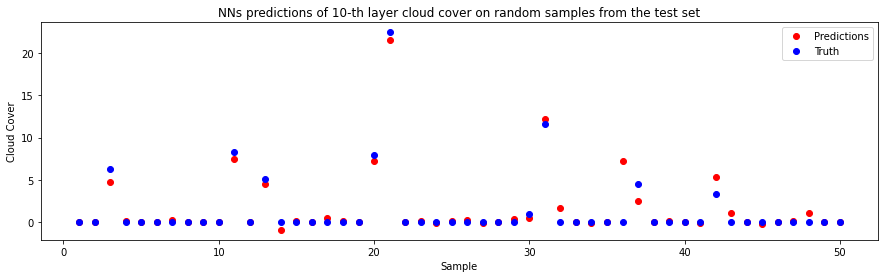

In [16]:
no_samples = 50
layer = 10
clc_pred = model.predict(input_test[:no_samples])[:, layer]
clc_true = output_test[:no_samples, layer]
a = np.linspace(1, no_samples, no_samples)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111, title='NNs predictions of %d-th layer cloud cover on random samples from the test set'%layer, 
                     xlabel='Sample', ylabel='Cloud Cover')
ax.plot(a, clc_pred, 'ro')
ax.plot(a, clc_true, 'bo')
ax.legend(['Predictions', 'Truth'])

Adding other NNs to compare, even though for those this test set was part of the learning set!!!

In [10]:
model_2 = load_model(os.path.join(model_path, 'model_grid_column_based_final_2.h5'))

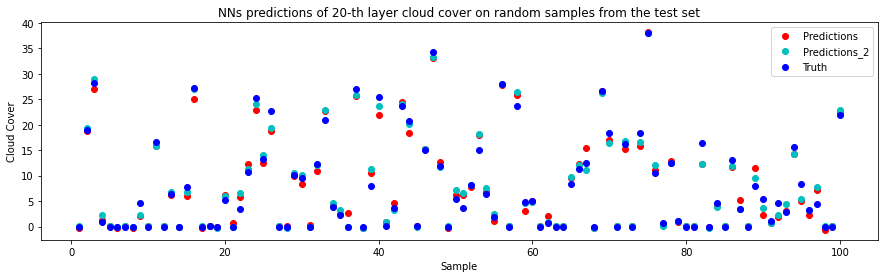

In [9]:
no_samples = 100
layer = 20
clc_pred = model.predict(input_test[:no_samples])[:,layer]
clc_pred_2 = model_2.predict(input_test[:no_samples])[:,layer]
clc_true = output_test[:no_samples, layer]
a = np.linspace(1, no_samples, no_samples)

fig = plt.figure(figsize=(15,4))
# Careful with saying that it's the 20th layer. It's from the perspective of an ICON-A grid with model height at 21km.
ax = fig.add_subplot(111, title='NNs predictions of %d-th layer cloud cover on random samples from the test set'%layer, 
                     xlabel='Sample', ylabel='Cloud Cover')
ax.plot(a, clc_pred, 'ro')
ax.plot(a, clc_pred_2, 'co')
ax.plot(a, clc_true, 'bo')
ax.legend(['Predictions', 'Predictions_2', 'Truth'])
fig.savefig('../figures/offline_testing_predictions_random_samples.pdf')

**Second visualization method** <br>
Mean profile of Cloud Cover on x-axis with Vertical Layer on y-axis. This time I can use the test set.

In [7]:
input_test_2 = np.load(os.path.join(data_path, 'cloud_cover_input_test_2.npy'))
output_test_2 = np.load(os.path.join(data_path, 'cloud_cover_output_test_2.npy'))

In [8]:
# Vertical layers
a = np.linspace(5, 31, 27)
# Cloud cover means for first model
clc_data_mean = []
for i in range(27):
    clc_data_mean.append(np.mean(output_test[:, i]))
# Cloud cover means for second model
clc_data_mean_2 = []
for i in range(27):
    clc_data_mean_2.append(np.mean(output_test_2[:, i]))
# Predicted cloud cover means
pred_adj = np.minimum(np.maximum(model.predict(input_test), 0), 100)
clc_mean = np.mean(pred_adj, axis=0)
pred_adj_2 = np.minimum(np.maximum(model_2.predict(input_test_2), 0), 100)
clc_mean_2 = np.mean(pred_adj_2, axis=0)

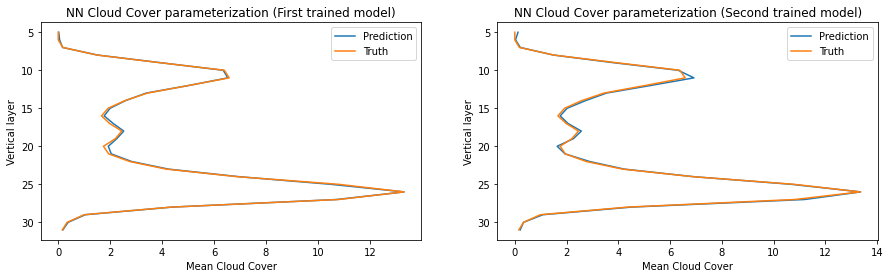

In [9]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (First trained model)')
ax_1.plot(clc_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(clc_mean_2, a)
ax_2.plot(clc_data_mean_2, a)
plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])
# Very curiously these plots used to be better when qc_4 was still included  
fig.savefig('../figures/offline_testing_mean_cloud_cover_NNs_2.pdf')

In [ ]:
fig = plt.figure(figsize=(15,4))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (First trained model)')
ax_1.plot(clc_mean, a)
ax_1.plot(clc_data_mean, a)
plt.gca().invert_yaxis()
ax_1.legend(['Prediction', 'Truth'])
# For model_2
ax_2 = fig.add_subplot(122, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(clc_mean_2, a)
ax_2.plot(clc_data_mean_2, a)
plt.gca().invert_yaxis()
ax_2.legend(['Prediction', 'Truth'])
# Very curiously these plots used to be better when qc_4 was still included  
fig.savefig('../figures/offline_testing_mean_cloud_cover_NNs.pdf')

On all NARVAL data

In [11]:
# Load data
input_train_2 = np.load(os.path.join(data_path, 'cloud_cover_input_train_2.npy'))
input_test_2 = np.load(os.path.join(data_path, 'cloud_cover_input_test_2.npy'))
output_train_2 = np.load(os.path.join(data_path, 'cloud_cover_output_train_2.npy'))
output_test_2 = np.load(os.path.join(data_path, 'cloud_cover_output_test_2.npy'))

input_valid_2 = np.load(os.path.join(data_path, 'cloud_cover_input_valid_2.npy'))
output_valid_2 = np.load(os.path.join(data_path, 'cloud_cover_output_valid_2.npy'))

In [12]:
input_data = np.concatenate((input_train, input_valid, input_test), axis=0)
output_data = np.concatenate((output_train, output_valid, output_test), axis=0)

input_data_2 = np.concatenate((input_train_2, input_valid_2, input_test_2), axis=0)
output_data_2 = np.concatenate((output_train_2, output_valid_2, output_test_2), axis=0)

In [13]:
# Vertical layers
a = np.linspace(5, 31, 27)
# Cloud cover means for first model
clc_data_mean = []
for i in range(27):
    clc_data_mean.append(np.mean(output_data[:, i]))

# Predicted cloud cover means
pred_adj = np.minimum(np.maximum(model.predict(input_data), 0), 100)
clc_mean = np.mean(pred_adj, axis=0)
pred_adj_2 = np.minimum(np.maximum(model_2.predict(input_data_2), 0), 100)
clc_mean_2 = np.mean(pred_adj_2, axis=0)

In [14]:
clc_mean

array([ 0.01957798,  0.05253388,  0.16547991,  1.5168297 ,  3.9382503 ,
        6.32812   ,  6.4934864 ,  5.024541  ,  3.3790243 ,  2.5882218 ,
        1.9968994 ,  1.7662972 ,  2.117203  ,  2.5311933 ,  2.2601795 ,
        1.9334778 ,  2.0583446 ,  2.8288033 ,  4.2522674 ,  6.967667  ,
       10.492099  , 13.341855  , 10.741383  ,  4.3720226 ,  1.0384021 ,
        0.37790278,  0.17620933], dtype=float32)

In [15]:
clc_mean_2

array([ 0.12409367,  0.02842776,  0.20964526,  1.4896768 ,  3.7989736 ,
        6.2836094 ,  6.8836665 ,  5.2357845 ,  3.530387  ,  2.7167659 ,
        2.0113728 ,  1.7467263 ,  2.0471444 ,  2.563959  ,  2.265435  ,
        1.640315  ,  1.9510975 ,  2.892033  ,  4.232141  ,  6.9207006 ,
       10.687958  , 13.358834  , 11.182864  ,  4.4872637 ,  1.0891832 ,
        0.3404389 ,  0.207943  ], dtype=float32)

In [16]:
clc_data_mean

[2.0478832779822219e-07,
 0.00033776531641375735,
 0.17631685094894642,
 1.5021955939963532,
 3.91492667002586,
 6.374820047557965,
 6.565577912452006,
 5.038709451760132,
 3.441732141836549,
 2.5728790195282016,
 1.9210425870789314,
 1.662810838855783,
 1.98459678258431,
 2.4587458429692153,
 2.213715613226061,
 1.7527898613467492,
 1.9661254388613016,
 2.766782176097001,
 4.177273559445905,
 6.919768079581624,
 10.806907746534359,
 13.354901893589245,
 10.814759942940318,
 4.354794731258838,
 0.9929281415331013,
 0.340165015890495,
 0.1563680778794108]

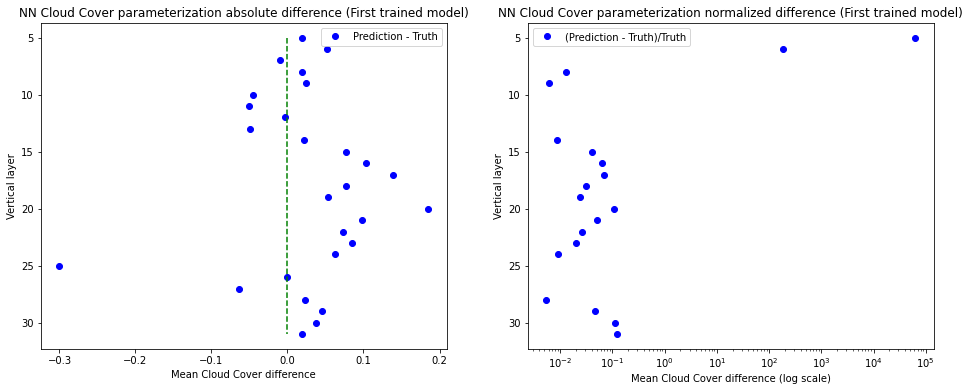

In [13]:
# Nando's suggestion: Panel showing the differences (absolute and/or normalised with the truth cloud cover)

fig = plt.figure(figsize=(16,6))
# For model
ax_1 = fig.add_subplot(121, xlabel='Mean Cloud Cover difference', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization absolute difference (First trained model)')
ax_1.plot(clc_mean - clc_data_mean, a, 'bo')
ax_1.plot(0*a, a, 'g--')
plt.gca().invert_yaxis()
ax_1.legend(['Prediction - Truth'])

ax_2 = fig.add_subplot(122, xscale='log', xlabel='Mean Cloud Cover difference (log scale)', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization normalized difference (First trained model)')
ax_2.plot((clc_mean - clc_data_mean)/clc_data_mean, a, 'bo')
# ax_2.plot(0*a, a, 'g--')
plt.gca().invert_yaxis()
ax_2.legend(['(Prediction - Truth)/Truth'])

*Computing the standard error of regression per vertical layer* <br>
The standard error of regression (ser) is defined as the square root of the variance of the residuals. Actually it's the same as the RMSE.

In [14]:
# Nando's suggestion: use a metric to test significance. SER is what comes closest, but significance is rather for classification problems
# Sidenote: Don't use R2, it's only for linear regression. Actually, R2 might be better after all: https://peerj.com/articles/cs-623/
# Caveats regarding R2: https://www.statology.org/standard-error-regression/
# The SER/RMSE does not say much about the performance of the regression with respect to the distribution of the ground truth elements!

ser = []
ser_2 = []
for i in range(27):
    ser.append(np.sqrt(np.mean((pred_adj[:, i] - output_test[:, i])**2)))
    ser_2.append(np.sqrt(np.mean((pred_adj_2[:, i] - output_test_2[:, i])**2)))

ser_total = np.sqrt(np.var(pred_adj - output_test))
ser_total_2 = np.sqrt(np.var(pred_adj_2 - output_test_2))

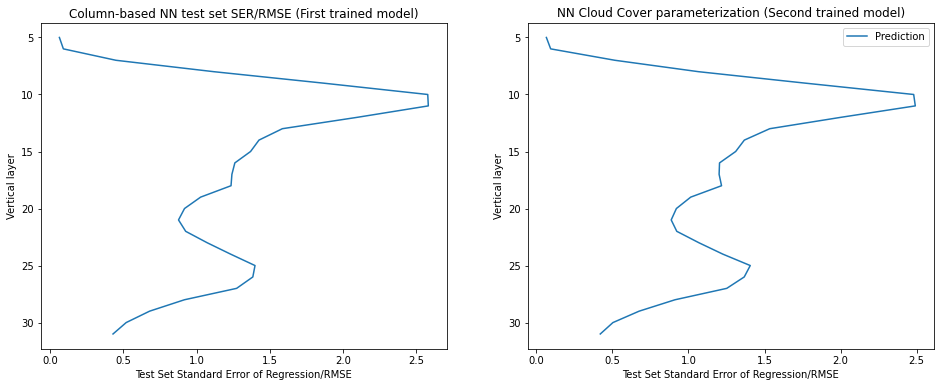

In [15]:
fig = plt.figure(figsize=(16,6))
# For model
ax_1 = fig.add_subplot(121, xlabel='Test Set Standard Error of Regression/RMSE', ylabel='Vertical layer', 
                       title='Column-based NN test set SER/RMSE (First trained model)')
ax_1.plot(ser, a)
# ax_1.plot(np.mean(ser)*np.ones(len(a)), a, 'g--')
plt.gca().invert_yaxis()
# ax_1.legend(['Prediction - Truth'])

ax_2 = fig.add_subplot(122, xlabel='Test Set Standard Error of Regression/RMSE', ylabel='Vertical layer', 
                       title='NN Cloud Cover parameterization (Second trained model)')
ax_2.plot(ser_2, a)
plt.gca().invert_yaxis()
plt.savefig('../figures/test_set_rmse_ser.pdf')
ax_2.legend(['Prediction', 'Truth'])

The cloud cover estimates per vertical layer are on average up to 2.8% off. <br>
The MSE was around 2 for both models while training, which would give us a RMSE of 1.41. This matches our total SER:

In [16]:
print('{}{:.3f}'.format('The total SER of the first model is ', ser_total))
print('{}{:.3f}'.format('The total SER of the second model is ', ser_total_2))

The total SER of the first model is 1.322
The total SER of the second model is 1.284


**Third visualization method** <br>
Hovmöller diagram (time on x-axis with vertical layers on y-axis and NN ensemble mean clc in color) <br>
Looking at the first day here.

In [6]:
os.listdir(os.path.join(root_path, 'my_work/NARVAL/data_var_vertinterp/qv'))

['int_var_qv_R02B04_NARVALII_2016080100_fg_DOM01_0033.nc',
 'int_var_qv_R02B04_NARVALII_2016082100_fg_DOM01_0028.nc',
 'int_var_qv_R02B04_NARVALII_2016081600_fg_DOM01_0032.nc',
 'int_var_qv_R02B04_NARVALII_2016080200_fg_DOM01_0021.nc',
 'int_var_qv_R02B04_NARVALI_2013121200_fg_DOM01_0035.nc',
 'int_var_qv_R02B04_NARVALI_2013120700_fg_DOM01_0027.nc',
 'int_var_qv_R02B04_NARVALI_2013120800_fg_DOM01_0028.nc',
 'int_var_qv_R02B04_NARVALII_2016080700_fg_DOM01_0023.nc',
 'int_var_qv_R02B04_NARVALII_2016081200_fg_DOM01_0034.nc',
 'int_var_qv_R02B04_NARVALI_2013120400_fg_DOM01_0032.nc',
 'int_var_qv_R02B04_NARVALI_2013120600_fg_DOM01_0031.nc',
 'int_var_qv_R02B04_NARVALII_2016080800_fg_DOM01_0028.nc',
 'int_var_qv_R02B04_NARVALI_2013120400_fg_DOM01_0026.nc',
 'int_var_qv_R02B04_NARVALI_2013120300_fg_DOM01_0026.nc',
 'int_var_qv_R02B04_NARVALI_2013120500_fg_DOM01_0013.nc',
 'int_var_qv_R02B04_NARVALI_2013120500_fg_DOM01_0025.nc',
 'int_var_qv_R02B04_NARVALI_2013122300_fg_DOM01_0016.nc',
 'int_v

In [4]:
# Get not_nan quickly
path = os.path.join(root_path, 'my_work/NARVAL/data_var_vertinterp/')
vars = ['clc']
for i in range(len(vars)):
    DS = xr.open_mfdataset(path+vars[i]+'/int_var_'+vars[i]+'_R02B04_NARVALI_2013120100_cloud_DOM01_00*.nc', 
                           combine='by_coords')
    da = getattr(DS, vars[i]).values
    not_nan = ~np.isnan(da[0,30,:])

*Loading the first day: 2013120100* 

Careful with the order of the variables!

In [4]:
# Loads the NARVAL data into the data_dict dictionary
order_of_vars = ['qv', 'qc', 'qi', 'temp', 'pres', 'rho', 'zg', 'fr_lake', 'clc']
data_dict = load_data(source='narval', days='dec_1st', vert_interp=True, order_of_vars=order_of_vars)

In [5]:
#Reshaping into nd-arrays of equaling shapes
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), 25, axis=0)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 0), 25, axis=0)

In [6]:
[print(key + ': ' + str(data_dict[key].shape)) for key in data_dict.keys()];

qv: (25, 31, 1024)
qc: (25, 31, 1024)
qi: (25, 31, 1024)
temp: (25, 31, 1024)
pres: (25, 31, 1024)
rho: (25, 31, 1024)
zg: (25, 31, 1024)
fr_lake: (25, 1024)
clc: (25, 31, 1024)


In [11]:
# One sample should contain a column of information
VERT_LAYERS = 31

data_dict_reshaped = {}
for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

# Remove constant columns
del data_dict_reshaped['zg_4']
del data_dict_reshaped['zg_5']
del data_dict_reshaped['zg_6']
del data_dict_reshaped['qc_4']

In [12]:
#Converting dict into a DataFrame-object 
df = pd.DataFrame.from_dict(data_dict_reshaped)
df.head()

,qv_4,qv_5,qv_6,qv_7,qv_8,qv_9,qv_10,qv_11,qv_12,qv_13,...,clc_21,clc_22,clc_23,clc_24,clc_25,clc_26,clc_27,clc_28,clc_29,clc_30
0,0.000003,0.000003,0.000003,0.000003,0.000005,0.000010,0.000028,0.000086,0.000101,0.000112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000003,0.000003,0.000003,0.000003,0.000005,0.000010,0.000033,0.000110,0.000138,0.000232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000003,0.000003,0.000003,0.000003,0.000004,0.000011,0.000037,0.000093,0.000118,0.000195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000003,0.000003,0.000003,0.000003,0.000005,0.000009,0.000033,0.000131,0.000177,0.000299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000003,0.000003,0.000003,0.000003,0.000006,0.000011,0.000016,0.000056,0.000084,0.000090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df.columns

Index(['qv_4', 'qv_5', 'qv_6', 'qv_7', 'qv_8', 'qv_9', 'qv_10', 'qv_11',
       'qv_12', 'qv_13',
       ...
       'clc_21', 'clc_22', 'clc_23', 'clc_24', 'clc_25', 'clc_26', 'clc_27',
       'clc_28', 'clc_29', 'clc_30'],
      dtype='object', length=213)

mean_1, std_1 = read_mean_and_std(os.path.join(model_path, 'model_grid_column_based_final_1.txt'))
mean_2, std_2 = read_mean_and_std(os.path.join(model_path, 'model_grid_column_based_final_2.txt'))

mean_1 = np.concatenate((mean_1, np.zeros(27)))
mean_2 = np.concatenate((mean_2, np.zeros(27)))
std_1 = np.concatenate((std_1, np.ones(27)))
std_2 = np.concatenate((std_2, np.ones(27)))*Scaling the data*

In [9]:
mean_1, std_1 = read_mean_and_std(os.path.join(model_path, 'model_grid_column_based_final_1.txt'))
mean_2, std_2 = read_mean_and_std(os.path.join(model_path, 'model_grid_column_based_final_2.txt'))

mean_1 = np.concatenate((mean_1, np.zeros(27)))
mean_2 = np.concatenate((mean_2, np.zeros(27)))
std_1 = np.concatenate((std_1, np.ones(27)))
std_2 = np.concatenate((std_2, np.ones(27)))

In [26]:
# Note that after standardization the mean and variance are not 0 and 1 respectively 
# as the data values above 21km are still in the data
df_1 = ((df - mean_1)/std_1).to_numpy()
df_2 = ((df - mean_2)/std_2).to_numpy()

*Drawing the diagram*

In [27]:
df_1.shape

(25600, 213)

In [28]:
# Draw the diagram
# All vertical layers from first time step
pred_clc_mat = np.zeros((25, 27))
for i in range(25):
    # Mean prediction for a specific time step 
    pred_1 = model.predict(df_1[1024*i: 1024*(i+1), :-27]) # Maybe I have the indexing wrong after all
    pred_adj_1 = np.mean(np.minimum(np.maximum(pred_1, 0), 100), axis=0)
    pred_2 = model_2.predict(df_2[1024*i: 1024*(i+1), :-27]) 
    pred_adj_2 = np.mean(np.minimum(np.maximum(pred_2, 0), 100), axis=0)
    pred_clc_mat[i,:] = 1/2*(pred_adj_1+pred_adj_2)       

In [29]:
data_clc_mat = np.zeros((25, 27))
for i in range(25):
    # Mean cloud cover for a specific time step 
    data_clc_1 = np.mean(df_1[1024*i: 1024*(i+1), -27:], axis=0)
    data_clc_2 = np.mean(df_2[1024*i: 1024*(i+1), -27:], axis=0)
    data_clc_mat[i,:] = 1/2*(data_clc_1+data_clc_2)

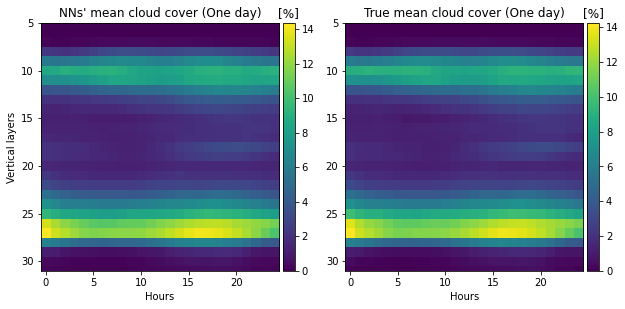

In [30]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

matrix = np.zeros((25, 32))
matrix_data = np.zeros((25, 32))
matrix[:, 5:] = pred_clc_mat
matrix_data[:, 5:] = data_clc_mat
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(10, 10))
ax_2 = fig.add_subplot(122, xlabel='Hours', ylim=[31, 5], title='True mean cloud cover (One day)')
ims_2 = ax_2.imshow(np.transpose(matrix_data))
# Colorbar axes
divider = make_axes_locatable(ax_2)
cax_2 = divider.append_axes("right", size="5%", pad=0.05)
cb_2 = fig.colorbar(ims_2, cax=cax_2)
cb_2.ax.set_title('[%]')
#fig.colorbar(ims_2)
ax_1 = fig.add_subplot(121, xlabel='Hours', ylabel='Vertical layers', ylim=[31, 5], 
                       title='NNs\' mean cloud cover (One day)')
ims_1 = ax_1.imshow(np.transpose(matrix))
# Colorbar axes
divider = make_axes_locatable(ax_1)
cax_1 = divider.append_axes("right", size="5%", pad=0.05)
cb_1 = fig.colorbar(ims_1, cax=cax_1)
#fig.colorbar(ims_1)
cb_1.ax.set_title('[%]')
fig.savefig('../figures/offline_testing_hovmoeller.pdf')

/pf/b/b309170/work/b309170/conda/envs/clouds113/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  app.launch_new_instance()


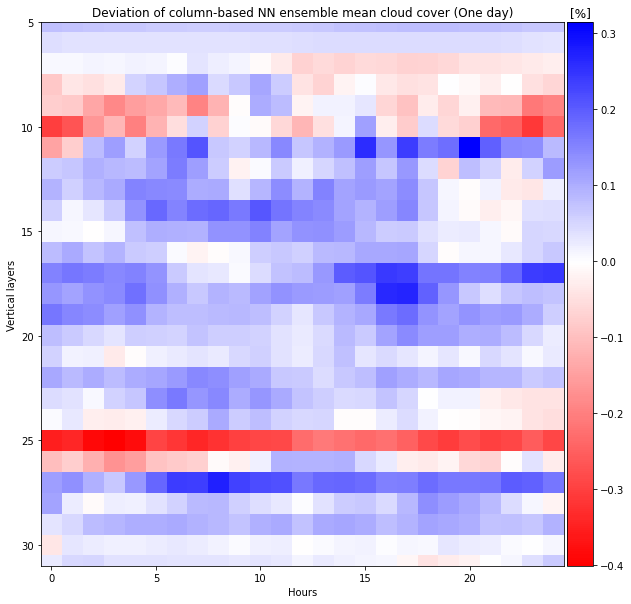

In [42]:
from matplotlib.colors import DivergingNorm

%matplotlib inline

matrix = np.zeros((25, 32))
matrix_data = np.zeros((25, 32))
matrix[:, 5:] = pred_clc_mat
matrix_data[:, 5:] = data_clc_mat
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(10, 10))

ax_1 = fig.add_subplot(111, xlabel='Hours', ylim=[31, 5], ylabel='Vertical layers', 
                       title='Deviation of column-based NN ensemble mean cloud cover (One day)')
ims_1 = ax_1.imshow(np.transpose(matrix) - np.transpose(matrix_data), norm=DivergingNorm(0), cmap='bwr_r')
# Colorbar axes
divider = make_axes_locatable(ax_1)
cax_1 = divider.append_axes("right", size="5%", pad=0.05)
cb_1 = fig.colorbar(ims_1, cax=cax_1)
cb_1.ax.set_title('[%]')
fig.savefig('../figures/offline_testing_column-based_hovmoeller_diff.pdf')

**Plot the timeseries for one specific grid column** <br>
*Gunnar's idea.* I can do it for August, 2016 (December, 2013 has some tricky days and I need a continuous stretch of days)

In [ ]:
# Loads the NARVAL data into the data_dict dictionary
order_of_vars = ['qv', 'qc', 'qi', 'temp', 'pres', 'rho', 'zg', 'fr_lake', 'clc']
data_dict = load_data(source='narval', days='august', vert_interp=True, order_of_vars=order_of_vars)

In [5]:
#Reshaping into nd-arrays of equaling shapes (745 = 24*31+1)
data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], 0), 745, axis=0)
data_dict['fr_lake'] = np.repeat(np.expand_dims(data_dict['fr_lake'], 0), 745, axis=0)

In [6]:
# One sample should contain a column of information
VERT_LAYERS = 31

data_dict_reshaped = {}
for key in data_dict.keys():
    if data_dict[key].shape[1] == VERT_LAYERS:  
        for i in range(4, VERT_LAYERS):
            new_key = '{}{}{:d}'.format(key,'_',i)
            data_dict_reshaped[new_key] = np.reshape(data_dict[key][:,i,:], -1)
    else:
        data_dict_reshaped[key] = np.reshape(data_dict[key], -1)

# Remove constant fields
del data_dict_reshaped['zg_4']
del data_dict_reshaped['zg_5']
del data_dict_reshaped['zg_6']
del data_dict_reshaped['qc_4']

In [7]:
#Converting dict into a DataFrame-object 
df = pd.DataFrame.from_dict(data_dict_reshaped)
df.head()

,qv_4,qv_5,qv_6,qv_7,qv_8,qv_9,qv_10,qv_11,qv_12,qv_13,...,clc_21,clc_22,clc_23,clc_24,clc_25,clc_26,clc_27,clc_28,clc_29,clc_30
0,0.000003,0.000003,0.000003,0.000004,0.000009,0.000020,0.000068,0.000128,0.000136,0.000160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000003,0.000003,0.000003,0.000005,0.000006,0.000019,0.000074,0.000120,0.000122,0.000163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000003,0.000003,0.000003,0.000004,0.000007,0.000017,0.000067,0.000114,0.000110,0.000159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000003,0.000003,0.000003,0.000005,0.000007,0.000023,0.000069,0.000094,0.000111,0.000218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000003,0.000003,0.000003,0.000003,0.000006,0.000021,0.000080,0.000147,0.000188,0.000319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Scale the data
df_scaled = ((df - mean_1)/std_1).to_numpy()

In [23]:
# Take a random horizontal field
m = 842

indices = [] 
for i in range(745):
    indices.append(m+i*1024)

timesteps = np.arange(745)
true_clc = data_dict['clc'][:,:,m] #time x vert x hor
pred_clc = np.maximum(np.minimum(model.predict(df_scaled[indices, :-27]),100),0)  #Have to reconstruct the mth field

In [14]:
true_clc.shape

(745, 31)

In [36]:
matrix_data.shape

(96, 32)

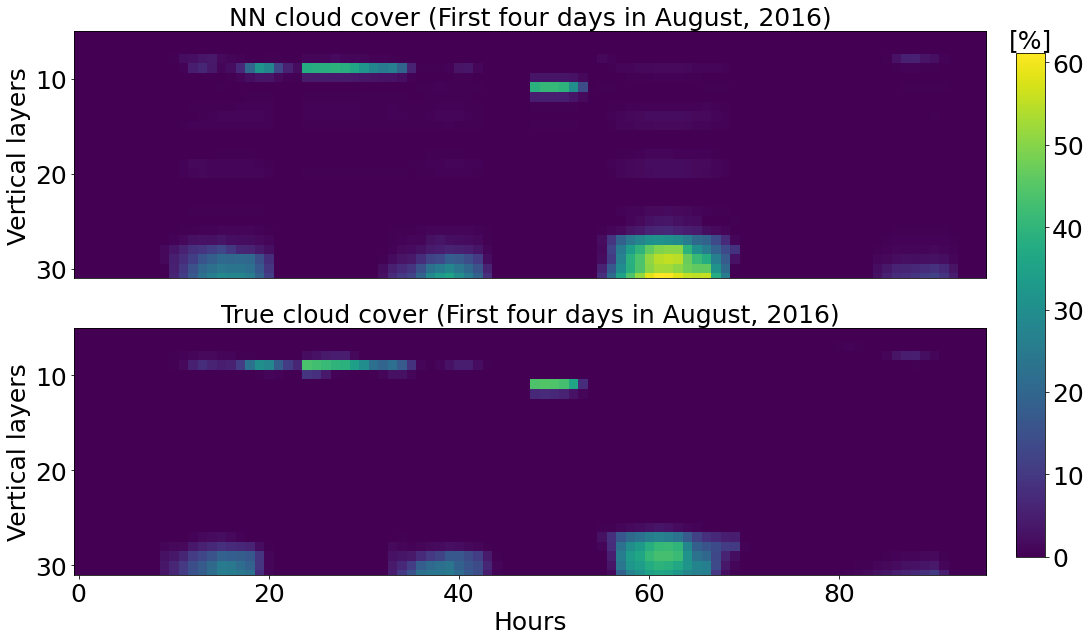

In [47]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

# With a huge font for the presentation
fontsize = 25
plt.rc('font', size=fontsize) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize) #fontsize of the legend

matrix = np.zeros((96, 32)) #np.zeros((745, 31))
matrix_data = np.zeros((96, 32))
matrix[:, 5:] = pred_clc[:96]
matrix_data[:, 5:] = true_clc[:96, 4:]
# Crucial so that the colorbar will actually match both plots
vmax = np.maximum(np.max(matrix), np.max(matrix_data))
vmin = np.minimum(np.min(matrix), np.min(matrix_data))
# t = np.linspace(1, 25, 25)
# v = np.linspace(9, 75)
# T, V = np.meshgrid(t, v)
fig = plt.figure(figsize=(20,10))
ax_2 = fig.add_subplot(212, xlabel='Hours', ylabel='Vertical layers', ylim=[31, 5], 
                       title='True cloud cover (First four days in August, 2016)')
im = ax_2.imshow(np.transpose(matrix_data),vmin=vmin, vmax=vmax)
# # Colorbar axes
# divider = make_axes_locatable(ax_2)
# cax_2 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(ims_2, cax=cax_2)
#fig.colorbar(ims_2)
ax_1 = fig.add_subplot(211, ylabel='Vertical layers', ylim=[31, 5], xticks=[],
                       title='NN cloud cover (First four days in August, 2016)')
im = ax_1.imshow(np.transpose(matrix),vmin=vmin, vmax=vmax)
# # Colorbar axes
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

#([0.85, 0.15, 0.05, 0.7])
# divider = make_axes_locatable(cbar_ax)
# cax_1 = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('[%]')
# fig.colorbar(ims_1)
# fig.savefig('../figures/offline_testing_column_in_beginning_of_august.pdf')

In [28]:
np.save('/pf/b/b309170/workspace_icon-ml/iconml_clc/additional_content/plots_offline_paper/auxiliary/offline_testing_column_in_beginning_of_august_data.npy', np.transpose(matrix_data))
np.save('/pf/b/b309170/workspace_icon-ml/iconml_clc/additional_content/plots_offline_paper/auxiliary/offline_testing_column_in_beginning_of_august_pred.npy', np.transpose(matrix))

**Forth visualization method** <br>
R2-value on x-axis with vertical layers on y-axis <br>

R2 = 1-SS_res/SS_tot, <br>
SS_res = total sum of squares (prop. to variance in the data) <br>
SS_tot = residual sum of squares

So R2 = 1 - MSE/Variance(Data), isn't it?

Best case: R2 = 1 <br>
If R2 < 0, then a constant output model would be better than the ML model.

In [11]:
input_data = np.concatenate((input_train, input_test), axis=0)
output_data = np.concatenate((output_train, output_test), axis=0)

In [12]:
(no_of_samples, no_features) = input_data.shape

In [13]:
output_data.shape

(1540301, 27)

In [17]:
# MSE per layer

from tensorflow.keras import backend as K
import gc

# Predicting is much faster with predict_on_batch
batch_size = no_of_samples//100
for i in range(1 + no_of_samples//batch_size):
    if i == 0:
        pred = model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])
    else:
        pred = np.concatenate((pred, model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])), axis=0)
    K.clear_session()
    gc.collect()

pred_adj = np.minimum(np.maximum(pred, 0), 100)  #Cloud Cover is enforced between 0 and 100. 
                                                 #This should also be done in practice
    
clc_mse = np.mean((pred_adj - output_data)**2, axis=0, dtype=np.float64)

In [18]:
# Variance of the data

clc_data_var = np.var(output_data, axis=0)
assert(len(clc_data_var) == len(clc_mse) == 27)

In [19]:
r2 = []
assert len(clc_mse) == len(clc_data_var) == 27
for i in range(27):
    r2.append(1 - clc_mse[i]/clc_data_var[i])

In [20]:
# The R2-values on the two uppermost layers are really bad
r2[:2]

[-720361.4375716654, -13.46696667620228]

In [22]:
# Well, with such a low variance
clc_data_var[:2]

array([5.73488791e-09, 5.90998435e-04])

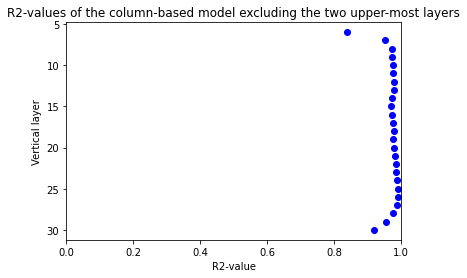

In [26]:
a = np.linspace(6, 30, 25)
fig = plt.figure()

ax = fig.add_subplot(111, xlim=(0, 1), title='R2-values of the column-based model excluding the two upper-most layers',
                     xlabel='R2-value', ylabel='Vertical layer')
ax.plot(r2[2:], a, 'bo')
plt.gca().invert_yaxis()
fig.savefig('../figures/column_based_r2-values.pdf')

In [23]:
r2

[-720361.4375716654,
 -13.46696667620228,
 0.8385921147746853,
 0.9532664857642843,
 0.9720653749076086,
 0.9742194217759714,
 0.9747798946868595,
 0.9769401140222785,
 0.9799722297191754,
 0.9788840637139712,
 0.9720775253716636,
 0.9698965616759012,
 0.9716782236325857,
 0.975023001538734,
 0.9789519124215493,
 0.9745725365015382,
 0.9788270528067893,
 0.9825510640733438,
 0.9837219613550517,
 0.985948548211242,
 0.9877470727713877,
 0.9903804562007693,
 0.9906706118552346,
 0.986886762085533,
 0.97453770971961,
 0.9537738471453958,
 0.9179424146309695]